In [1]:
from tracer import TracerData, TracerPlayer
from LSTM import Model, FingerDataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch

# 1. Creating data

In [6]:
data_motion = TracerData(timer=1.5, num_frames=20)

In [7]:
#record fingers trace
data_motion.record_trace()

In [8]:
#get recorded trace
arr = data_motion.get_trace()

Error: the path length is less than 20


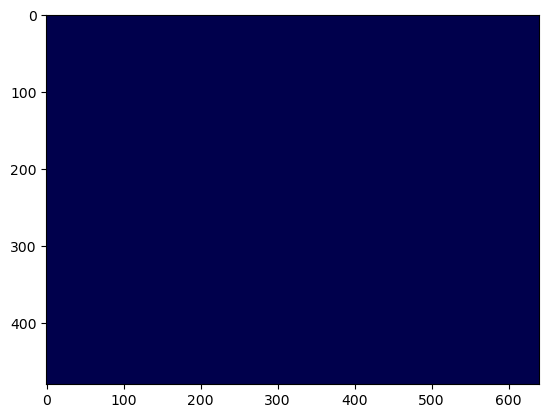

In [9]:
#plot recorded trace
data_motion.image()

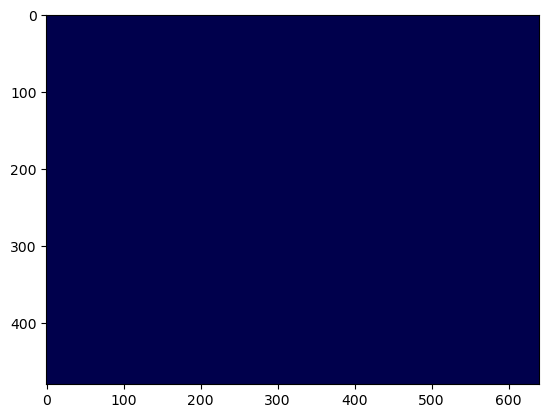

In [12]:
#you can create your own dataset
#Example: dataset for up_volume motion
up_volume = []
data_motion.record_trace()
data_motion.image() #check the correctness

In [13]:
#append trace to array
up_volume.append(data_motion.get_trace())
print(len(up_volume))

Error: the path length is less than 20
1


In [851]:
#save it
np.save('data20/up_volume.npy', np.array(up_volume))

# 2. Augmentation

In [21]:
#here you can augment your data
up_volume = np.load('data20/up_volume.npy')
low_volume = np.load('data20/low_volume.npy')
data_next = np.load('data20/next_track.npy')
trash = np.load('data20/trash.npy')
stop = np.load('data20/stop.npy')

In [22]:
arrays = [up_volume, low_volume, data_next, trash, stop]
for i, arr in enumerate(arrays):
    add = []
    for sample in arr:
        add.append(sample+np.random.normal(0,0.05,[20,10]))
    arrays[i] = np.concatenate((arr, add))
    
print(f'up volume length: {len(arrays[0])}')
print(f'low volume length: {len(arrays[1])}')
print(f'next track length: {len(arrays[2])}')
print(f'trash motion length: {len(arrays[3])}')
print(f'stop track length: {len(arrays[4])}')

np.save('data20/up_volume_aug.npy', arrays[0])
np.save('data20/low_volume_aug.npy', arrays[1])
np.save('data20/next_aug.npy', arrays[2])
np.save('data20/trash_aug.npy', arrays[3])
np.save('data20/stop_aug.npy', arrays[4])

up volume length: 100
low volume length: 100
next track length: 100
trash motion length: 100
stop track length: 100


# 3. Dataset and DataLoader

In [23]:
#DATASET
paths = ['data20/up_volume_aug.npy', 'data20/low_volume_aug.npy', 'data20/next_aug.npy', 'data20/trash_aug.npy', 'data20/stop_aug.npy']
data = FingerDataset(paths)
print(data.__len__())

500


In [24]:
#DATALOADER
data_loader = DataLoader(data, shuffle=True, batch_size=10)

# 4. Model training

In [29]:
num_layers = 1
hidden_size = 100
model = Model(num_layers, hidden_size, 5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
#TRAINING MODEL
num_epochs = 200
for epoch in range(num_epochs):
    for images, labels in data_loader:
        out = model(images.to(torch.float))
        
        optimizer.zero_grad()
        loss = criterion(out.to(torch.float), labels)
        loss.backward()
        optimizer.step()
    if epoch %10 ==0:
        print(f'Epoch: {epoch}, loss: {loss}')

Epoch: 0, loss: 0.5370053648948669


In [2]:
#SAVE MODEL
torch.save(model.state_dict(), 'model20.pth')

NameError: name 'model' is not defined

In [2]:
#LOAD MODEL
num_layers = 1
hidden_size = 100
model = Model(num_layers, hidden_size, 5)
model.load_state_dict(torch.load('model20.pth'))
model.eval()

Model(
  (lstm): LSTM(10, 100, batch_first=True)
  (l1): Linear(in_features=100, out_features=5, bias=True)
  (relu): ReLU()
)

# 5. Testing

In [3]:
playlist_path = "C:/Users/Artem/Desktop/Artem/volume_hand_project/Playlist"
play = TracerPlayer(playlist_path, model, 20)

In [4]:
play.listen(60)